<a href="https://colab.research.google.com/github/rohskopf/potentials-workshop-2022/blob/main/potentials_workshop_fitsnap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.7-venv
!pip install --upgrade pip
!pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
%cd /content
!git clone -b compute-pace https://github.com/jmgoff/lammps_compute_PACE
%cd lammps_compute_PACE
!mkdir build
%cd build
!cmake -D LAMMPS_EXCEPTIONS=on \
       -D PKG_PYTHON=on \
       -D BUILD_SHARED_LIBS=on \
       -D CMAKE_BUILD_TYPE=Debug \
       -D PKG_ML-IAP=on \
       -D PKG_ML-PACE=on \
       -D PKG_ML-SNAP=on \
       -D BUILD_MPI=on \
       -D BUILD_OMP=off \
       -D PKG_MOLECULE=on ../cmake/

# next, download the modified lammps-user-pace code that contains extra arrays for breaking out descriptor contributions

!git clone https://github.com/jmgoff/lammps-user-pace-1
!cp lammps-user-pace-1/ML-PACE/ace-evaluator/ace_evaluator.* ./lammps-user-pace-v.2022.09.27/ML-PACE/ace-evaluator/

# compile lammps

!make -j 2
!make install-python
%env PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps_compute_PACE/build

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,020 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 htt

In [2]:
import lammps
lmp = lammps.lammps()

In [20]:
!pip install ase nglview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00
  Created wheel for nglview: filename=nglview-3.0.3-py3-none-any.whl size=8057538 sha256=61d038680a212bde3a527dca91c20957c9ad64652252a9a335b3ee1413827e0b
  Stored in directory: /root/.cache/pip/wheels/38/fb/56/e7e63827c04c176832cbdf7816eb09e7118f725cac018370ad
Successfully built nglview


In [8]:
%cd /content/lammps_compute_PACE/examples/pace/multi-elem

!ls

!python test_en.py

/content/lammps_compute_PACE/examples/pace/multi-elem
coupling_coefficients.yace  latte_cell_0.data  log.lammps  README.md
latte_cell_0_chi_i.npy	    latte_cell_0.xyz   loop.sh	   test_en.py
running latte_cell_0.xyz
LAMMPS (15 Sep 2022)
Total wall time: 0:00:00
Made LAMMPS instance
----- cutoffmax: 5.700000
global shape (77925, 94)


In [14]:
import numpy as np
import ase
from ase.io import read,write
from ase.visualize import view

In [22]:
atoms = read("latte_cell_0.xyz")
view(atoms, viewer='x3d')
#write('image.png', atoms)

In [ ]:
# simulation settings
fname = "latte_cell_0.data"
lmp.command("clear") # must clear previous lammps commands before running
lmp.command("info all out log")
lmp.command('units  metal')
lmp.command('atom_style  atomic')
lmp.command("boundary    p p p")
lmp.command("atom_modify    map hash")
lmp.command('neighbor  2.3 bin')
lmp.command('boundary  p p p')
lmp.command(f"read_data  {fname}")
lmp.command('mass  1 1.00')
lmp.command('mass  2 14.00')
lmp.command('mass  3 15.999')

# potential settings

lmp.command(f"pair_style     zero 5.7")
lmp.command(f"pair_coeff     * *")

# compute ACE coefficients, with dgradflag = 0

lmp.command(f"compute pace all pace coupling_coefficients.yace 1 0")

# evaluate potential with no timesteps

lmp.command("run 0")

lmp_pace = lmp.numpy.extract_compute("pace", 0, 2)
print(np.shape(lmp_pace))

The resulting array is organized like:

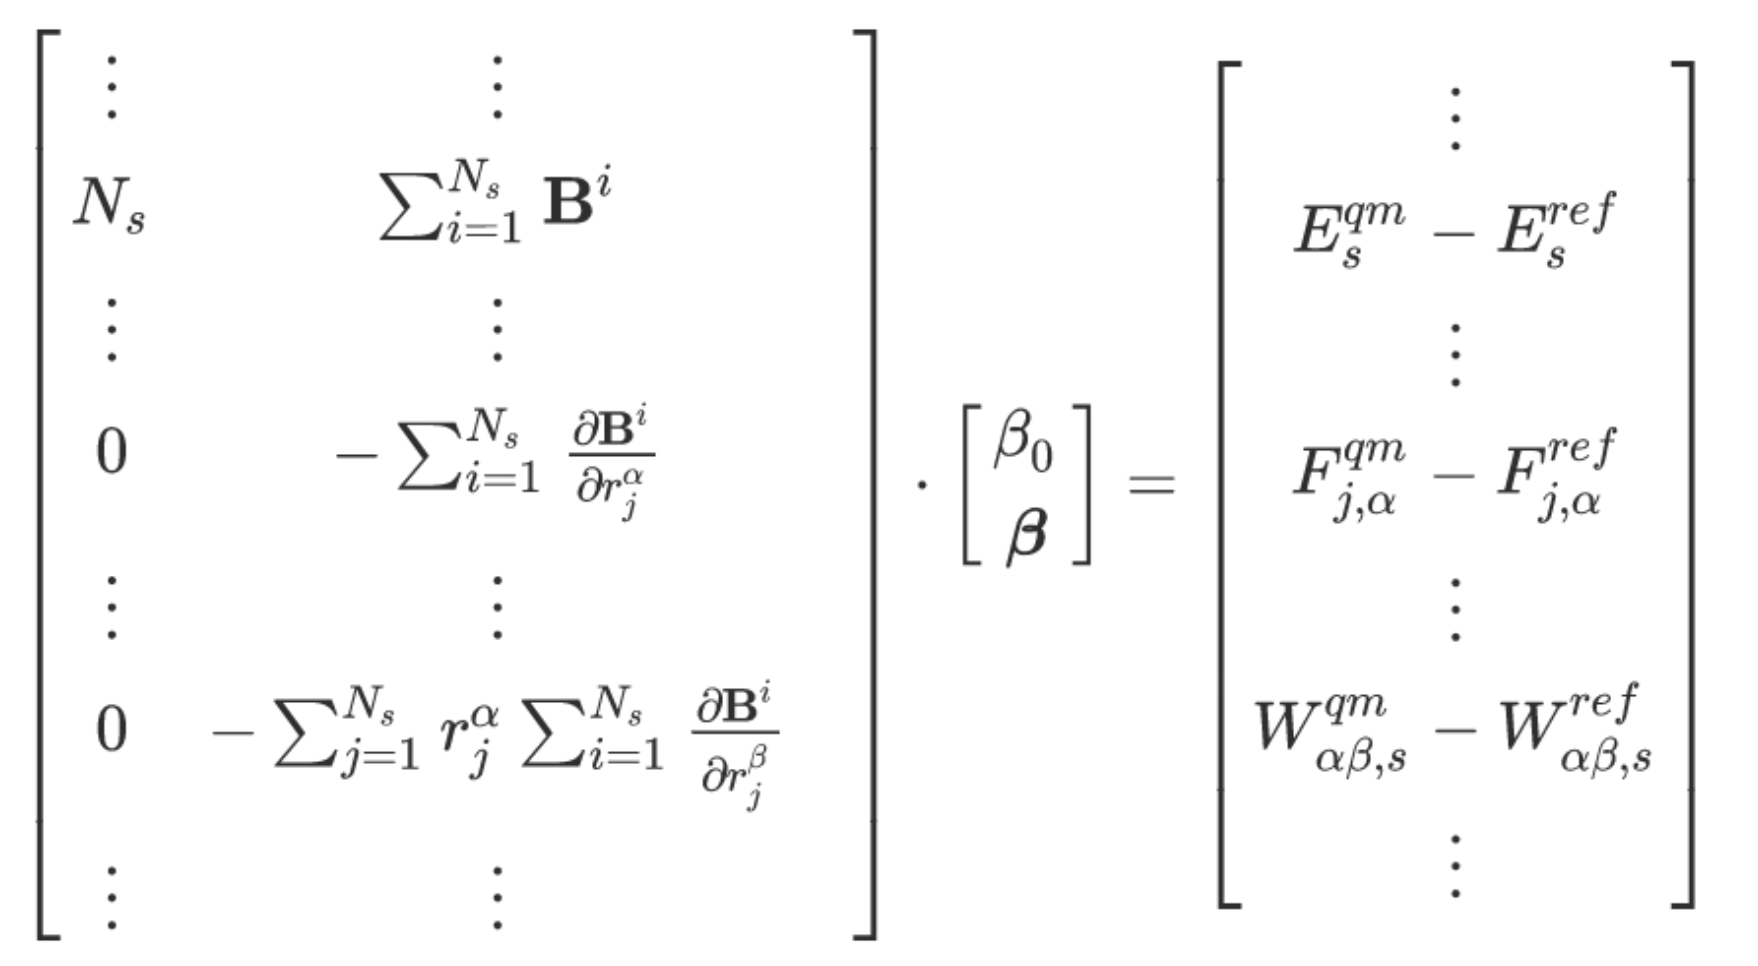

For fitting nonlinear models, we need each descriptor and descriptor gradient separately. For this we use a different option in the compute, as shown below.

In [25]:
# simulation settings
fname = "latte_cell_0.data"
lmp.command("clear") # must clear previous lammps commands before running
lmp.command("info all out log")
lmp.command('units  metal')
lmp.command('atom_style  atomic')
lmp.command("boundary    p p p")
lmp.command("atom_modify    map hash")
lmp.command('neighbor  2.3 bin')
lmp.command('boundary  p p p')
lmp.command(f"read_data  {fname}")
lmp.command('mass  1 1.00')
lmp.command('mass  2 14.00')
lmp.command('mass  3 15.999')

# potential settings

lmp.command(f"pair_style     zero 5.7")
lmp.command(f"pair_coeff     * *")

# compute ACE coefficients

lmp.command(f"compute pace all pace coupling_coefficients.yace 1 1")

# evaluate potential with no timesteps

lmp.command("run 0")

# extract compute
# extra args tell lammps API what data type is expected; see lammps docs

lmp_pace = lmp.numpy.extract_compute("pace", 0, 2)
print(np.shape(lmp_pace))

(77925, 94)


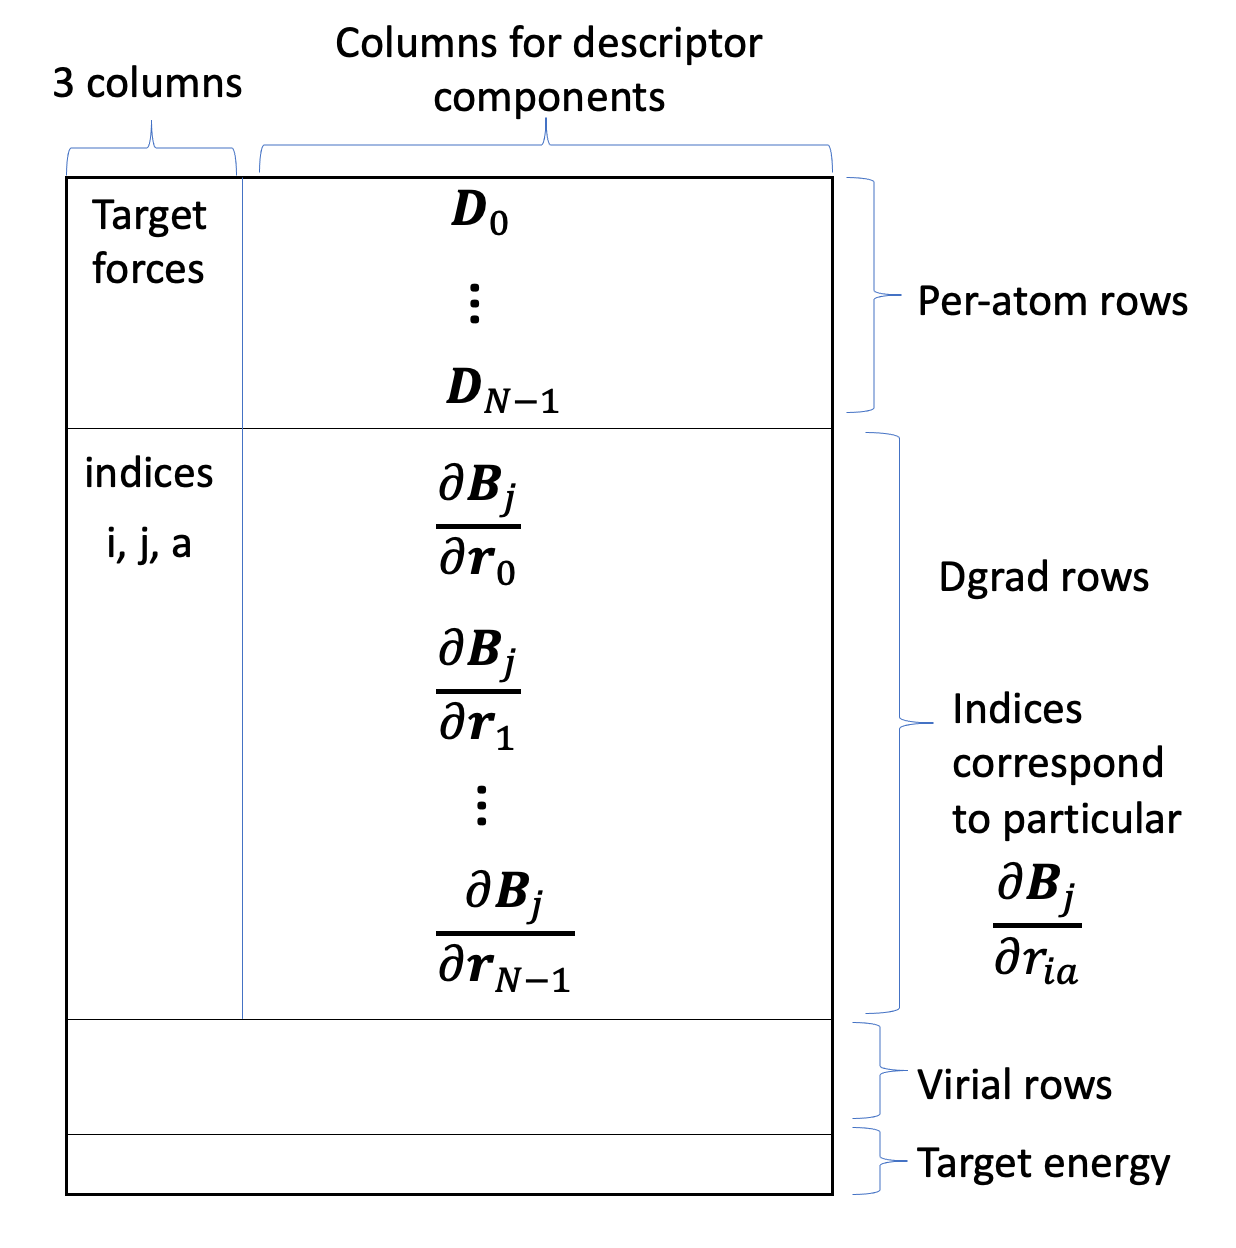

Show picture of how array is organized here.

In [28]:
# simulation settings
fname = "latte_cell_0.data"
lmp.command("clear")
lmp.command("info all out log")
lmp.command('units  metal')
lmp.command('atom_style  atomic')
lmp.command("boundary    p p p")
lmp.command("atom_modify    map hash")
lmp.command('neighbor  2.3 bin')
# boundary
lmp.command('boundary  p p p')
# read atoms
lmp.command(f"read_data  {fname}")
lmp.command('mass  1 1.00')
lmp.command('mass  2 14.00')
lmp.command('mass  3 15.999')

# potential settings

lmp.command(f"pair_style     zero 5.7")
lmp.command(f"pair_coeff     * *")

# compute ACE coefficients, with dgradflag = 0

lmp.command(f"compute pace all pace coupling_coefficients.yace 1 0")

# evaluate potential with no timesteps

lmp.command("run 0")

lmp_pace = lmp.numpy.extract_compute("pace", 0, 2)
print(np.shape(lmp_pace))

(650, 274)
